# Импорты

In [1]:
import pickle
import gc

import catboost as cb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from malware_src.prepare_data import dataframe_to_pool
from malware_src.visualization import plot_roc_curve

# Загрузка и разделение данных

In [2]:
dtypes = {
    'EngineVersion':                                     'category',
    'AppVersion':                                        'category',
    'AvSigVersion':                                      'category',
    'RtpStateBitfield':                                  'category',
    'DefaultBrowsersIdentifier':                         'category',
    'AVProductStatesIdentifier':                         'category',
    'AVProductsInstalled':                               'category',
    'AVProductsEnabled':                                 'category',
    'CountryIdentifier':                                 'category',
    'CityIdentifier':                                    'category',
    'OrganizationIdentifier':                            'category',
    'GeoNameIdentifier':                                 'category',
    'LocaleEnglishNameIdentifier':                       'category',
    'Platform':                                          'category',
    'Processor':                                         'category',
    'OsVer':                                             'category',
    'OsBuild':                                           'category',
    'OsSuite':                                           'category',
    'OsPlatformSubRelease':                              'category',
    'OsBuildLab':                                        'category',
    'SkuEdition':                                        'category',
    'IsProtected':                                       'category',
    'IeVerIdentifier':                                   'category',
    'SmartScreen':                                       'category',
    'Firewall':                                          'category',
    'Census_MDC2FormFactor':                             'category',
    'Census_OEMNameIdentifier':                          'category',
    'Census_OEMModelIdentifier':                         'category',
    'Census_ProcessorManufacturerIdentifier':            'category',
    'Census_ProcessorModelIdentifier':                   'category',
    'Census_ProcessorClass':                             'category',
    'Census_PrimaryDiskTypeName':                        'category',
    'Census_HasOpticalDiskDrive':                        'category',
    'Census_ChassisTypeName':                            'category',
    'Census_PowerPlatformRoleName':                      'category',
    'Census_InternalBatteryType':                        'category',
    'Census_OSVersion':                                  'category',
    'Census_OSArchitecture':                             'category',
    'Census_OSBranch':                                   'category',
    'Census_OSBuildNumber':                              'category',
    'Census_OSBuildRevision':                            'category',
    'Census_OSEdition':                                  'category',
    'Census_OSSkuName':                                  'category',
    'Census_OSInstallTypeName':                          'category',
    'Census_OSInstallLanguageIdentifier':                'category',
    'Census_OSUILocaleIdentifier':                       'category',
    'Census_OSWUAutoUpdateOptionsName':                  'category',
    'Census_GenuineStateName':                           'category',
    'Census_ActivationChannel':                          'category',
    'Census_FlightRing':                                 'category',
    'Census_FirmwareManufacturerIdentifier':             'category',
    'Census_FirmwareVersionIdentifier':                  'category',
    'Census_IsSecureBootEnabled':                        'category',
    'Census_IsTouchEnabled':                             'category',
    'Census_IsPenCapable':                               'category',
    'Census_IsAlwaysOnAlwaysConnectedCapable':           'category',
    'Wdft_IsGamer':                                      'category',
    'Wdft_RegionIdentifier':                             'category',
    'HasDetections':                                     'category',
    'Census_ProcessorCoreCount':                         'float16',
    'Census_PrimaryDiskTotalCapacity':                   'float64',
    'Census_SystemVolumeTotalCapacity':                  'float64',
    'Census_TotalPhysicalRAM':                           'float32',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches': 'float32',
    'Census_InternalPrimaryDisplayResolutionHorizontal': 'float32',
    'Census_InternalPrimaryDisplayResolutionVertical':   'float32',
    'Census_InternalBatteryNumberOfCharges':             'float64'
}

TARGET_COLUMN = 'HasDetections'

In [3]:
categorical_cols = [el for el in dtypes if dtypes[el] == 'category']
numerical_cols = [el for el in dtypes if dtypes[el] != 'category']

In [4]:
seed = 2019
val_part = 0.2
hold_part = 0.02

In [6]:
%%time
data_path = 'data/filtered_train_data.csv'
data = pd.read_csv(data_path, dtype=dtypes)

Wall time: 2min 25s


In [7]:
data.shape[0]

8921483

## Подготовка данных для моделей из naive bayes

In [8]:
enc = OrdinalEncoder()

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8921483 entries, 0 to 8921482
Data columns (total 67 columns):
EngineVersion                                        category
AppVersion                                           category
AvSigVersion                                         category
RtpStateBitfield                                     category
DefaultBrowsersIdentifier                            category
AVProductStatesIdentifier                            category
AVProductsInstalled                                  category
AVProductsEnabled                                    category
CountryIdentifier                                    category
CityIdentifier                                       category
OrganizationIdentifier                               category
GeoNameIdentifier                                    category
LocaleEnglishNameIdentifier                          category
Platform                                             category
Processor          

In [10]:
# Убрать все NaN в категориальных столбцах
category_data = pd.DataFrame(data, columns=categorical_cols)
for col in categorical_cols:
    try:
        category_data.loc[:, col] = category_data[col].fillna('-1')
    except:
        category_data[col] = category_data[col].cat.add_categories('-1')
        category_data.loc[:, col] = category_data[col].fillna('-1')

In [11]:
enc.fit(category_data)

OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)

In [14]:
category_data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8921483 entries, 0 to 8921482
Data columns (total 59 columns):
EngineVersion                              8921483 non-null category
AppVersion                                 8921483 non-null category
AvSigVersion                               8921483 non-null category
RtpStateBitfield                           8921483 non-null category
DefaultBrowsersIdentifier                  8921483 non-null category
AVProductStatesIdentifier                  8921483 non-null category
AVProductsInstalled                        8921483 non-null category
AVProductsEnabled                          8921483 non-null category
CountryIdentifier                          8921483 non-null category
CityIdentifier                             8921483 non-null category
OrganizationIdentifier                     8921483 non-null category
GeoNameIdentifier                          8921483 non-null category
LocaleEnglishNameIdentifier                8921483 non-null

In [13]:
filtered_category_data = enc.transform(category_data)

In [15]:
numeric_data = pd.DataFrame(data, columns=numerical_cols)

In [16]:
filtered_numeric_data = numeric_data.to_numpy()

In [17]:
# Убрать все NaN в числовых столбцах
for col in numerical_cols:
    try:
        numeric_data.loc[:, col] = numeric_data[col].fillna(-1)
    except:
        numeric_data[col] = numeric_data[col].cat.add_categories(-1)
        numeric_data.loc[:, col] = numeric_data[col].fillna(-1)

In [18]:
full_data = np.concatenate((filtered_numeric_data, filtered_category_data), axis=1)

In [19]:
full_data

array([[4.00000e+00, 4.76940e+05, 2.99451e+05, ..., 1.00000e+00,
        2.00000e+00, 0.00000e+00],
       [4.00000e+00, 4.76940e+05, 1.02385e+05, ..., 1.00000e+00,
        1.40000e+01, 0.00000e+00],
       [4.00000e+00, 1.14473e+05, 1.13907e+05, ..., 1.00000e+00,
        9.00000e+00, 0.00000e+00],
       ...,
       [8.00000e+00, 2.44198e+05, 2.42989e+05, ..., 1.00000e+00,
        1.30000e+01, 1.00000e+00],
       [2.00000e+00, 4.76940e+05, 4.63486e+05, ..., 1.00000e+00,
        5.00000e+00, 1.00000e+00],
       [4.00000e+00, 9.53869e+05, 6.37127e+05, ..., 1.00000e+00,
        3.00000e+00, 0.00000e+00]])

In [20]:
gc.collect()

140

### Разделение данных на тестовую и проверочную выборки

In [21]:
train_data, val_data = train_test_split(full_data, test_size=val_part, random_state=seed)

In [22]:
train_data = np.nan_to_num(train_data)
val_data = np.nan_to_num(val_data)

In [23]:
train_data

array([[8.00000e+00, 9.76762e+05, 9.61343e+05, ..., 1.00000e+00,
        1.10000e+01, 1.00000e+00],
       [4.00000e+00, 9.53869e+05, 9.52773e+05, ..., 2.00000e+00,
        2.00000e+00, 1.00000e+00],
       [4.00000e+00, 9.53869e+05, 9.53031e+05, ..., 2.00000e+00,
        2.00000e+00, 0.00000e+00],
       ...,
       [4.00000e+00, 4.76940e+05, 2.28746e+05, ..., 2.00000e+00,
        1.30000e+01, 1.00000e+00],
       [4.00000e+00, 9.53869e+05, 9.41186e+05, ..., 1.00000e+00,
        2.00000e+00, 0.00000e+00],
       [4.00000e+00, 4.76940e+05, 1.90774e+05, ..., 1.00000e+00,
        1.10000e+01, 0.00000e+00]])

In [24]:
val_data

array([[2.00000e+00, 6.10480e+05, 1.00000e+05, ..., 1.00000e+00,
        9.00000e+00, 0.00000e+00],
       [4.00000e+00, 4.76940e+05, 4.50325e+05, ..., 2.00000e+00,
        2.00000e+00, 1.00000e+00],
       [2.00000e+00, 4.76940e+05, 4.76373e+05, ..., 1.00000e+00,
        2.00000e+00, 0.00000e+00],
       ...,
       [4.00000e+00, 9.53869e+05, 9.53318e+05, ..., 1.00000e+00,
        7.00000e+00, 1.00000e+00],
       [4.00000e+00, 3.05245e+05, 5.12070e+04, ..., 1.00000e+00,
        1.00000e+00, 0.00000e+00],
       [4.00000e+00, 4.76940e+05, 3.06743e+05, ..., 1.00000e+00,
        1.00000e+00, 1.00000e+00]])

## Обучение моделей

### GaussianNB

In [25]:
gauss_model = GaussianNB()

In [26]:
%%time
gauss_model.fit(train_data[:,0:-1], train_data[:,-1])

Wall time: 12.7 s
Parser   : 114 ms


GaussianNB(priors=None, var_smoothing=1e-09)

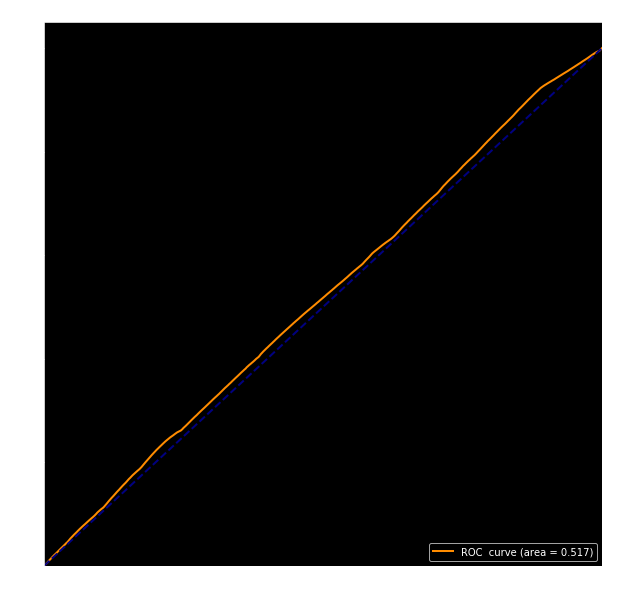

In [30]:
plt.figure(figsize=(10,10))
plot_roc_curve(true=val_data[:,-1],
               pred=gauss_model.predict_proba(val_data[:,0:-1])[:,1],
               name='ROC-кривая на валидационном датасете',
               p_label=1)

In [31]:
gc.collect()

7062

### BernoulliNB

In [32]:
bernoulli_model = BernoulliNB()

In [33]:
%%time
bernoulli_model.fit(train_data[:,0:-1], train_data[:,-1])

Wall time: 9.27 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

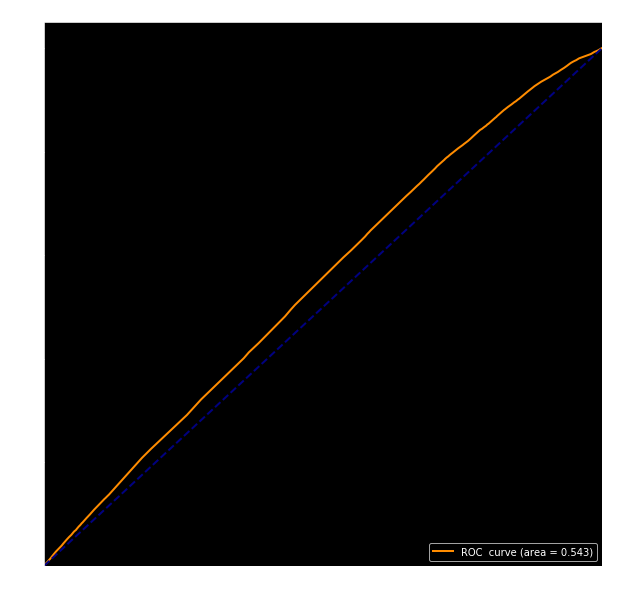

In [35]:
plt.figure(figsize=(10,10))
plot_roc_curve(true=val_data[:,-1],
               pred=bernoulli_model.predict_proba(val_data[:,0:-1])[:,1],
               name='ROC-кривая на валидационном датасете',
               p_label=1)

# Подготовка данных для Catboost

###  Обучение

In [36]:
train_val_data, hold_data = train_test_split(data, test_size=hold_part, random_state=seed)
train_data, val_data = train_test_split(train_val_data, test_size=val_part, random_state=seed)

In [37]:
print(data.shape[0], train_data.shape[0], val_data.shape[0], hold_data.shape[0])

8921483 6994442 1748611 178430


In [38]:
try:
    categorical_cols.remove(TARGET_COLUMN)
except Exception as ex:
    print(ex)
train_pool = dataframe_to_pool(train_data, numerical_cols, categorical_cols, TARGET_COLUMN)
val_pool = dataframe_to_pool(val_data, numerical_cols, categorical_cols, TARGET_COLUMN)

In [ ]:
hold_data.to_csv('data/hold_data.csv', index=False)

In [39]:
gc.collect()

4594

In [40]:
model = cb.CatBoostClassifier(iterations=100, learning_rate = 0.3)

In [42]:
%%time
model.fit(train_pool, eval_set=val_pool, plot=True, verbose=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6659609	test: 0.6658177	best: 0.6658177 (0)	total: 14.5s	remaining: 23m 59s
1:	learn: 0.6502108	test: 0.6498260	best: 0.6498260 (1)	total: 27.7s	remaining: 22m 35s
2:	learn: 0.6423387	test: 0.6419243	best: 0.6419243 (2)	total: 41s	remaining: 22m 4s
3:	learn: 0.6371035	test: 0.6366149	best: 0.6366149 (3)	total: 50.6s	remaining: 20m 13s
4:	learn: 0.6338038	test: 0.6332174	best: 0.6332174 (4)	total: 1m	remaining: 19m 5s
5:	learn: 0.6318516	test: 0.6312395	best: 0.6312395 (5)	total: 1m 10s	remaining: 18m 16s
6:	learn: 0.6301854	test: 0.6295066	best: 0.6295066 (6)	total: 1m 19s	remaining: 17m 36s
7:	learn: 0.6285788	test: 0.6278327	best: 0.6278327 (7)	total: 1m 28s	remaining: 17m 2s
8:	learn: 0.6276245	test: 0.6267885	best: 0.6267885 (8)	total: 1m 38s	remaining: 16m 35s
9:	learn: 0.6267443	test: 0.6258466	best: 0.6258466 (9)	total: 1m 47s	remaining: 16m 11s
10:	learn: 0.6261198	test: 0.6251940	best: 0.6251940 (10)	total: 1m 57s	remaining: 15m 50s
11:	learn: 0.6256070	test: 0.624

In [44]:
model_path = 'models/model.cb'
model.save_model(model_path)

In [45]:
feature_importance = model.get_feature_importance()
features = model.feature_names_

for feature_id in feature_importance.argsort()[::-1]:
    name = features[feature_id]
    importance = feature_importance[feature_id]
    print(f'{name:50}\t\t{importance}')

SmartScreen                                       		34.7943601535956
AVProductStatesIdentifier                         		13.853567782873736
AVProductsInstalled                               		5.498047296969141
AppVersion                                        		4.494099458456841
EngineVersion                                     		4.146383112654197
Census_ProcessorModelIdentifier                   		4.0202985813037975
AvSigVersion                                      		3.421595089106621
CountryIdentifier                                 		2.773681225618472
Wdft_IsGamer                                      		2.703384333437612
Census_OSInstallTypeName                          		2.4692666823566047
Census_OEMModelIdentifier                         		1.474884528985771
Wdft_RegionIdentifier                             		1.4179157100027286
Census_ActivationChannel                          		1.2450214311940013
Census_TotalPhysicalRAM                           		1.1744333778298162
Census_OEMNameI

### Тест

In [49]:
model.load_model('models/model.cb')

In [46]:
hold_data = pd.read_csv('data/hold_data.csv', dtype=dtypes)

In [47]:
hold_pool = dataframe_to_pool(hold_data, numerical_cols, categorical_cols, TARGET_COLUMN)

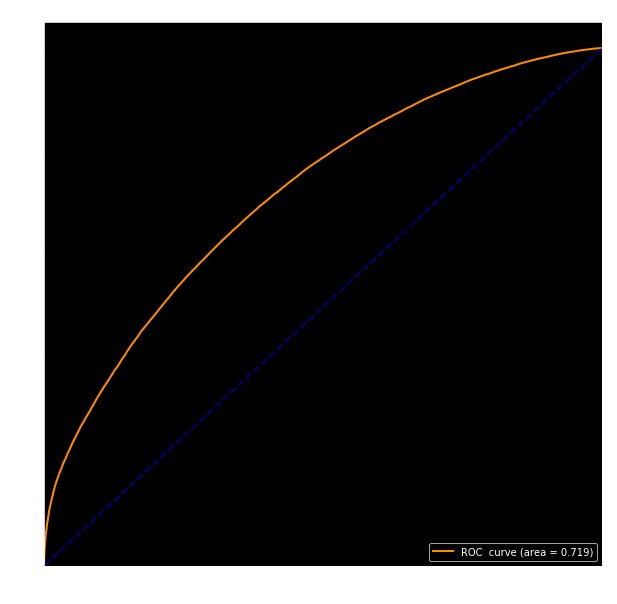

In [50]:
plt.figure(figsize=(10,10))
plot_roc_curve(true=hold_pool.get_label(),
               pred=model.predict_proba(hold_pool)[:,1],
               name='ROC-кривая на валидационном датасете',
               p_label='1')